# A2C on Hopper v4

In [1]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import A2CLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [2]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

## Setting parameters


In [3]:
num_cells = 256
lr = 2e-5
max_grad_norm = 1.0

frames_per_batch = 1000
#total_frames = 250_000
#total_frames = 10_000
total_frames = 1_000_000

gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4


## Environment setup

In [4]:
env_name = "Hopper-v4"
base_env = GymEnv(env_name, device=device)

#name of the run
run_id = 1
run_name = f'A2C_{env_name}_{run_id}_{total_frames}'

env = TransformedEnv(
    base_env,
    Compose(
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
check_env_specs(env)

2025-02-21 21:34:01,802 [torchrl][INFO] check_env_specs succeeded!


## Policy (Actor)


In [5]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

policy_module = TensorDictModule(actor_net, in_keys=["observation"], out_keys=["loc", "scale"])

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
)

## Value network (Critic)


In [6]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(module=value_net, in_keys=["observation"])

In [7]:
# Initialize LazyLinear layers with a dummy input
dummy_input = env.reset()["observation"].unsqueeze(0)  # Create a dummy batch of observations

# Forward pass through actor and critic networks to initialize LazyLinear layers
with torch.no_grad():
    policy_module(dummy_input)  # Initialize actor
    value_module(dummy_input)   # Initialize critic

print("Actor and Critic networks initialized.")

Actor and Critic networks initialized.


## Data collector


In [8]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

# Replay buffer
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

## Loss function for A2C

In [9]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)
loss_module = A2CLoss(
    actor_network=policy_module,
    critic_network=value_module,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

## Training loop

In [10]:
optim = torch.optim.Adam(loss_module.parameters(), lr)
logs = defaultdict(list)
pbar = tqdm(total=total_frames)

logs["step_count"] = []
logs["Max Step Count (Test)"] = []
logs["eval reward"] = []
logs["lr"] = []

for i, tensordict_data in enumerate(collector):
    advantage_module(tensordict_data)
    data_view = tensordict_data.reshape(-1)
    replay_buffer.extend(data_view.cpu())
    
    for _ in range(frames_per_batch // 64):
        subdata = replay_buffer.sample(64)
        loss_vals = loss_module(subdata.to(device))
        loss_value = (
            loss_vals["loss_objective"] + 
            loss_vals["loss_critic"] + 
            loss_vals["loss_entropy"]
        )

        loss_value.backward()
        torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
        optim.step()
        optim.zero_grad()

    # Store training rewards
    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    logs["lr"].append(optim.param_groups[0]["lr"])
    
    # Update progress bar
    cum_reward_str = f"Avg reward: {logs['reward'][-1]:.4f} (init: {logs['reward'][0]:.4f})"
    stepcount_str = f"Step count (max): {logs['step_count'][-1]}"
    lr_str = f"LR policy: {logs['lr'][-1]:.4f}"
    
    if i % 10 == 0:
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["Return (Test)"].append(eval_rollout["next", "reward"].sum().item())
            logs["Max Step Count (Test)"].append(eval_rollout["step_count"].max().item())
        
        eval_str = (
            f"Eval cumulative reward: {logs['Return (Test)'][-1]:.4f} "
            f"(init: {logs['Return (Test)'][0]:.4f}), "
            f"Eval step-count: {logs['Max Step Count (Test)'][-1]}"
        )
        del eval_rollout

    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

pbar.close()

Eval cumulative reward: 38.1742 (init: 38.1742), Eval step-count: 66, Avg reward: 1.0514 (init: 0.6534), Step count (max): 75, LR policy: 0.0000:   0%|          | 0/10000 [00:16<?, ?it/s]


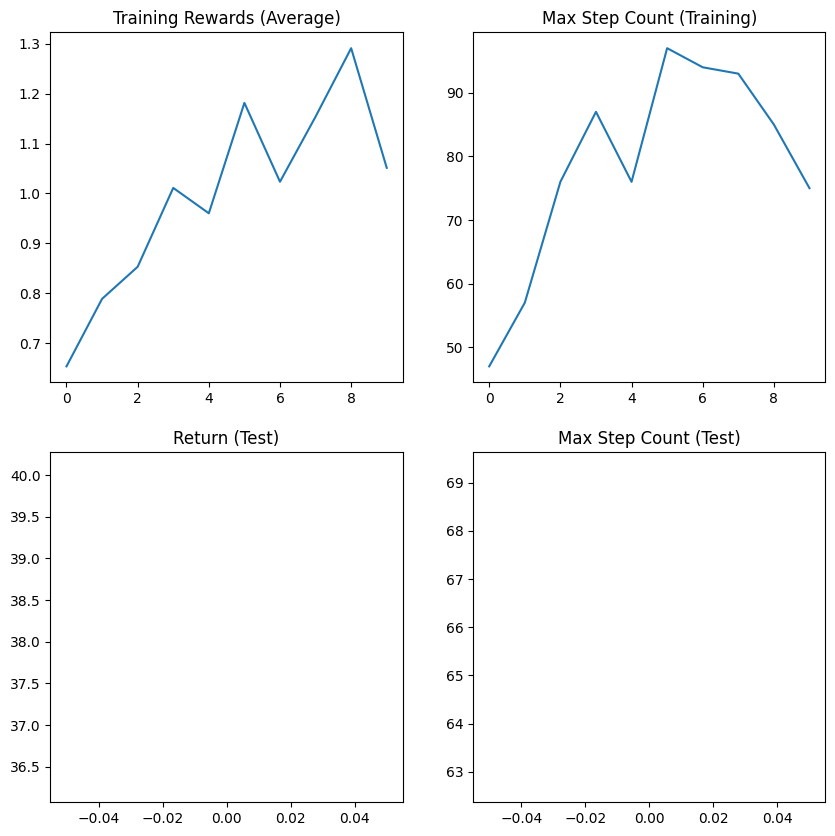

In [11]:
plt.figure(figsize=(10, 10))

# Training rewards
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("Training Rewards (Average)")

# Max step count during training
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max Step Count (Training)")

# Evaluation return
plt.subplot(2, 2, 3)
plt.plot(logs["Return (Test)"])
plt.title("Return (Test)")

# Max step count during evaluation
plt.subplot(2, 2, 4)
plt.plot(logs["Max Step Count (Test)"])
plt.title("Max Step Count (Test)")

plt.savefig(f'../runs/A2C/plots_{run_name}.jpg', dpi=150)
plt.show()


## Saving logs and model

In [12]:
# Define save path
save_path = f"../runs/A2C/{run_name}.pth"

# Create a dictionary
checkpoint = {
    "policy_state_dict": policy_module.state_dict(),
    "value_state_dict": value_module.state_dict(),
    "optimizer_state_dict": optim.state_dict(),
    "hyperparameters": {
        "num_cells": num_cells,
        "lr": lr,
        "gamma": gamma,
        "lmbda": lmbda,
        "entropy_eps": entropy_eps,
    }
}

# Save checkpoint
torch.save(checkpoint, save_path)
print(f"Model saved to {save_path}")

Model saved to ../runs/A2C/A2C_Hopper-v4_10000.pth


In [13]:
import pandas as pd

# Find the maximum length of any logged metric
max_length = max(len(logs[key]) for key in logs)

# Pad all lists to match max_length
for key in logs:
    while len(logs[key]) < max_length:
        logs[key].append(None)  # Fill with None (or np.nan)

# Convert to DataFrame
df_logs = pd.DataFrame.from_dict(logs)

# Save to CSV
df_logs.to_csv(f"../runs/A2C/logs_{run_name}.csv", index=False)

print("Logs saved")


Logs saved to training_logs.csv


# rendering

import time

# Create an environment with rendering enabled
render_env = GymEnv("Hopper-v4", device=device, render_mode="human")

# Reset environment
tensordict = render_env.reset()
done = False

# Execute policy in a loop
with torch.no_grad():
    while not done:
        tensordict["observation"] = tensordict["observation"].to(torch.float32)  # Convert dtype
        action = policy_module(tensordict)  # Get action from trained policy
        tensordict = render_env.step(action)  # Step in environment
        render_env.render()  # Render environment
        time.sleep(0.02)  # Add a small delay for smooth visualization
        done = tensordict["done"].item()  # Check if episode is over

# Close environment
render_env.close()
